Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Estimate the Number of Clusters

* Comparing with elbow method, there're other methods can estimate the number of clusters. 
* Here we 
  1. simulate different clusters of data
  2. all use k-means to get predicted labels
  3. compare different cluster count estimation methods

* Reference
  * https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd
  * https://github.com/smazzanti/are_you_still_using_elbow_method/blob/main/are-you-still-using-elbow-method.ipynb
  
* Observations
  * The datasets used here are different from what were used in the reference. According to the observations here, elbow works better than other estimated methods.

In [37]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import sklearn.metrics as sklearn_metrics
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


import warnings
warnings.filterwarnings('ignore')

In [2]:
def kmeans_labels(X, n_clusters):
    """
    Get k-means predicted labels.
    """
    if n_clusters == 1:  # when there's only 1 cluster, all label as 0
        return np.repeat(a=0, repeats=len(X))
    else:
        return KMeans(n_clusters=n_clusters).fit(X).labels_
    
    
def inertia_score(X, labels):
    """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

    inertia = 0
    for label in set(labels):
        X_cluster = X[labels == label, :]
        centroid = np.mean(X_cluster, axis=0)
        inertia += np.sum((X_cluster - centroid) ** 2)
    return inertia


def calinski_harabasz_score(X, labels):
    """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
    if len(set(labels)) == 1:
        return float("NaN")
    else:
        return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
    """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
    if len(set(labels)) == 1:
        return float("NaN")
    else:
        return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
    """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
    if len(set(labels)) == 1:
        return float("NaN")
    else:
        return sklearn_metrics.silhouette_score(X, labels)


def bic_score(X: np.ndarray, labels: np.array):
    """
      BIC score for the goodness of fit of clusters.
      This Python function is translated from the Golang implementation by the author of the paper. 
      The original code is available here: https://github.com/bobhancock/goxmeans/blob/a78e909e374c6f97ddd04a239658c7c5b7365e5c/km.go#L778
    """
    
    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = X.shape[1]

    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    loglikelihood = 0
    for label_name in set(labels):
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)
        centroid = np.mean(X_cluster, axis=0)
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
          - (n_points_cluster - 1) / 2
    
    bic = loglikelihood - (n_parameters / 2) * np.log(n_points)
        
    return bic

## Generate Data

In [3]:
n_samples = 800
np.random.seed(10)
cluster_sets = {}

noisy_circles_X, noisy_circles_y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
cluster_sets['noisy_circles'] = {'X': noisy_circles_X, 'y_true': noisy_circles_y, 'clusters_true': 2}

noisy_moons_X, noisy_moons_y = datasets.make_moons(n_samples=n_samples, noise=0.05)
cluster_sets['noisy_moons'] = {'X': noisy_moons_X, 'y_true': noisy_moons_y, 'clusters_true': 2}

blobs_3cen_X, blobs_3cen_y = datasets.make_blobs(
    n_samples=n_samples, n_features=2, 
    cluster_std=np.random.randint(low=10, high=20, size=3)/10, centers=3, random_state=10
)
cluster_sets['blobs_3cen'] = {'X': blobs_3cen_X, 'y_true': blobs_3cen_y, 'clusters_true': 3}

blobs_5cen_X, blobs_5cen_y = datasets.make_blobs(
    n_samples=n_samples, n_features=2, 
    cluster_std=np.random.randint(low=10, high=20, size=5)/10, centers=5, random_state=10
)
cluster_sets['blobs_5cen'] = {'X': blobs_5cen_X, 'y_true': blobs_5cen_y, 'clusters_true': 5}

blobs_5cen_mix_X, blobs_5cen_mix_y = datasets.make_blobs(
    n_samples=n_samples, n_features=2, 
    cluster_std=np.random.randint(low=10, high=50, size=5)/10, centers=5, random_state=10
)
cluster_sets['blobs_5cen_mix'] = {'X': blobs_5cen_mix_X, 'y_true': blobs_5cen_mix_y, 'clusters_true': 5}

blobs_10cen_X, blobs_10cen_y = datasets.make_blobs(
    n_samples=n_samples, n_features=2, 
    cluster_std=np.random.randint(low=10, high=20, size=10)/10, centers=10, random_state=10
)
cluster_sets['blobs_10cen'] = {'X': blobs_10cen_X, 'y_true': blobs_10cen_y, 'clusters_true': 10}

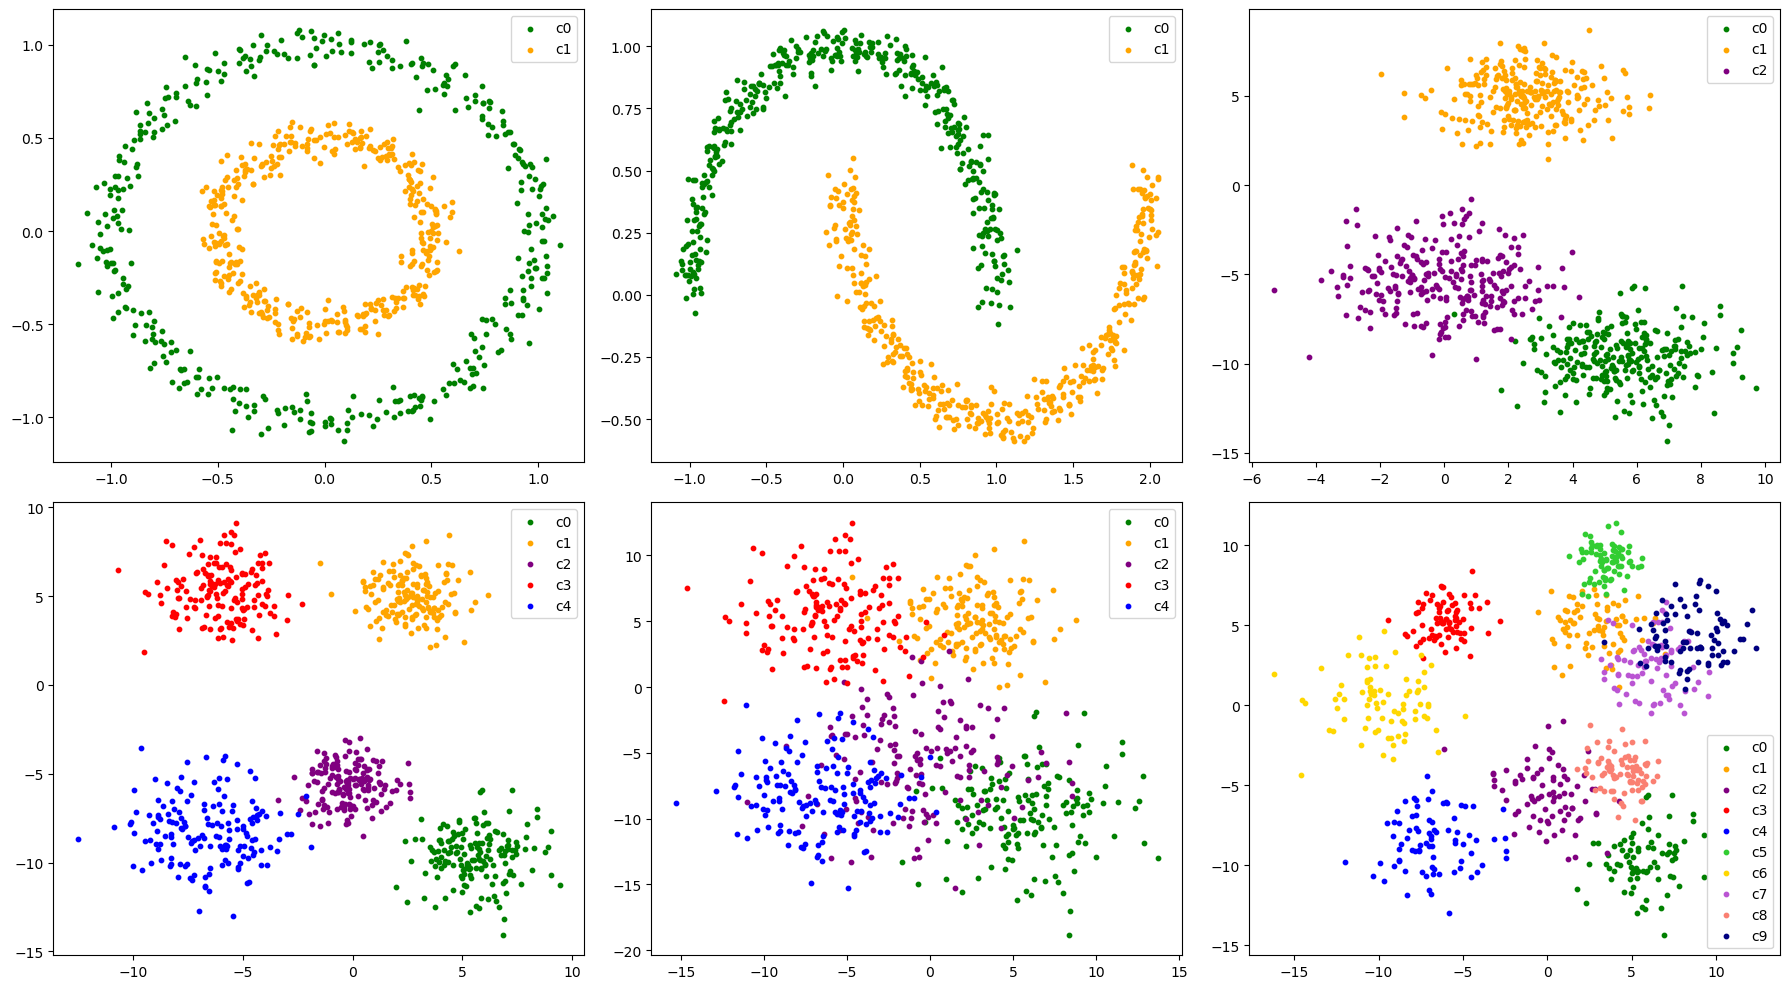

In [28]:
i = 0
n_rows = 2
n_cols = 3
colors = ['green', 'orange', 'purple', 'red', 'blue', 'limegreen', 'gold', 'mediumorchid', 'salmon', 'navy', 
         'turquoise', 'olive', 'indigo', 'deeppink', 'royalblue', 'cyan', 'yellowgreen', 'slateblue', 'plum', 'deepskyblue']

fig=plt.figure(figsize=(18, 10))
for cluster_name, cluster_values in cluster_sets.items():
    i += 1
    ax=fig.add_subplot(n_rows,n_cols,i) 
    X, y = cluster_values['X'], cluster_values['y_true']
    unique_ys = np.unique(y)
    for j in unique_ys:
        plt.scatter(X[y == j, 0], X[y == j, 1], color=colors[j], s=10, label=f'c{j}')
    plt.legend()
    
fig.tight_layout()
plt.show()

## K-means Predict Lables

In [4]:
possible_ks = list(range(2, 25))
scores_dct = {'elbow': {}, 
              'calinski_harabasz': {},
              'davies_bouldin': {},
              'silhouette': {},
              'bic': {}
             }  # for each estimate method, for each dataset, it will store the score of each k
summary_dct = {
              'elbow': {}, 
              'calinski_harabasz': {},
              'davies_bouldin': {},
              'silhouette': {},
              'bic': {}
              }


for cluster_name, cluster_values in cluster_sets.items():
    X, y_true = cluster_values['X'], cluster_values['y_true']
    
    scores_dct['elbow'][cluster_name] = []
    scores_dct['calinski_harabasz'][cluster_name] = []
    scores_dct['davies_bouldin'][cluster_name] = []
    scores_dct['silhouette'][cluster_name] = []
    scores_dct['bic'][cluster_name] = []
    
    for k in possible_ks:
        labels = kmeans_labels(X, n_clusters=k)
        
        scores_dct['elbow'][cluster_name].append(inertia_score(X, labels))
        scores_dct['calinski_harabasz'][cluster_name].append(calinski_harabasz_score(X, labels))
        scores_dct['davies_bouldin'][cluster_name].append(davies_bouldin_score(X, labels))
        scores_dct['silhouette'][cluster_name].append(silhouette_score(X, labels))
        scores_dct['bic'][cluster_name].append(bic_score(X, labels))
        
    elbow_k = KneeLocator(possible_ks, scores_dct['elbow'][cluster_name], curve='convex', direction='decreasing').knee  # elbow, find the knee point with max curvature
    ch_k = np.nanargmax(scores_dct['calinski_harabasz'][cluster_name])  # calinski-harabasz, higher the better
    db_k = np.nanargmin(scores_dct['davies_bouldin'][cluster_name])  # davies-bouldin, lower the better
    st_k = np.nanargmax(scores_dct['silhouette'][cluster_name])  # silhouette, higher the better
    bic_k = np.nanargmax(scores_dct['bic'][cluster_name])  # bic, higher the better
    
    summary_dct['elbow'][cluster_name] = elbow_k
    summary_dct['calinski_harabasz'][cluster_name] = ch_k
    summary_dct['davies_bouldin'][cluster_name] = db_k
    summary_dct['silhouette'][cluster_name] = st_k
    summary_dct['bic'][cluster_name] = bic_k

In [20]:
summary_dct['TRUE_CLUSTERS'] = {}

for cluster_name, cluster_dct in cluster_sets.items():
    summary_dct['TRUE_CLUSTERS'][cluster_name] =  cluster_dct['clusters_true']
    
summary_df = pd.DataFrame.from_dict(summary_dct)
summary_df

,elbow,calinski_harabasz,davies_bouldin,silhouette,bic,TRUE_CLUSTERS
noisy_circles,6,22,19,19,21,2
noisy_moons,8,22,9,8,21,2
blobs_3cen,4,1,0,0,1,3
blobs_5cen,5,3,3,3,3,5
blobs_5cen_mix,5,2,1,2,2,5
blobs_10cen,7,8,2,2,8,10


In [22]:
summary_tdf = summary_df.T
summary_tdf

,noisy_circles,noisy_moons,blobs_3cen,blobs_5cen,blobs_5cen_mix,blobs_10cen
elbow,6,8,4,5,5,7
calinski_harabasz,22,22,1,3,2,8
davies_bouldin,19,9,0,3,1,2
silhouette,19,8,0,3,2,2
bic,21,21,1,3,2,8
TRUE_CLUSTERS,2,2,3,5,5,10


<Axes: xlabel='true clusters #', ylabel='estimated clusters #'>

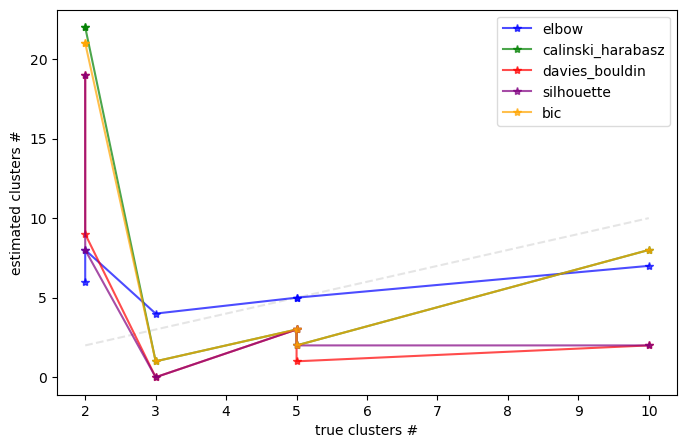

In [41]:
color_dct = {'elbow': 'blue', 'calinski_harabasz': 'green', 'davies_bouldin': 'red', 'silhouette': 'purple', 'bic': 'orange'}

plt.figure(figsize=(8,5))
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(summary_tdf.loc['TRUE_CLUSTERS'].values, summary_tdf.loc['TRUE_CLUSTERS'].values, label='', color='grey', alpha=0.2, linestyle='--')

for method in summary_tdf.index:
    if method == 'TRUE_CLUSTERS':
        continue
    ax.plot(summary_tdf.loc['TRUE_CLUSTERS'].values, summary_tdf.loc[method].values, label=method, color=color_dct[method], marker='*', alpha=0.7)

leg = plt.legend()
leg.get_frame().set_alpha(0.7)  # set legend's transparency
plt.xlabel('true clusters #')
plt.ylabel('estimated clusters #')
plt.title('')
display(ax)